## FX Project
Zhilin Liu $ \ \ $ N15584048 $\ \ \$ Spring 2020

In [28]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# FX Smile Calibration Problem

### From Black Scholes:
The Black Scholes model provides a convenient formula for deriving the prices of
european style options. The model has a number of useful properties which have led to its
universal use:

- The first such property is that option values are independent of any risk
preference. 
- The second is that there is only one input parameter for the formula that is not
directly observable in the market – the volatility of the underlying asset. At the time of pricing, all of the other variables are clear and known, but volatility must be an estimate.

***However***, the key assumption behind the Black Scholes model is that the asset performs a random walk over time, where the returns on the asset are normally distributed with a ***constant*** volatility. In other words, if the Black-Scholes model were completely correct, then the implied volatility surface across strike prices and time to maturity should be flat. In practice, this is not the case. It is ***stochastic***. And we can see it from IV using real market data and BS formula.


Facts:

- The implied volatility is the volatility backed out from the market option price
using the Black Scholes formula. 

- If the market were consistent with the Black Scholes
model then the implied volatility would be the same for all options. In practice the
implied volatility is found to vary with both maturity and strike price. This surface is
known as the volatility smile.

-----

### The Volatility Smile:

We actually want to calibrate a vol surface which fit market data (option prices) very well, obtaining more accurate volatilities, to help us price options more accurately. 

#### Two main types of calibration problems:

- Exact smile calibration problem
    
    Given a triple of (ATM, RR25, BF25) or tuple (ATM, RR25, BF25, RR10, BF10, ...), together with FX spot and interest rate curves, calibrate a model to fit exactly the given market data.

- Approximate smile calibration problem
    
    Given market data, calibrate a model to minimize errors in the fit to the given market data. Exactly what objective function is minimized is a choice.

Note: 

An institution which intends to hold and hedge its trades generally prefers exact calibration if at all possible. This is so that exact sensitivity to the more liquid vanilla positions is given cleanly for hedging with those instruments.

Note: 

- Exact calibration requires exactly the same number of model parameters as market instruments. 
- Approximate calibration requires at least as many market instruments as model parameters.

------
### How to calibrate? 

1/ Curve-fitting:

    • spline in some coordinate
    • quadratic in delta (Malz)
    • SVI (Gatheral)
    • Vanna-Volga
    • mixture of lognormals (*)
    • other ad-hoc curve choices

Curve-fitting approaches just give an implied vol curve, i.e. the
prices of European vanilla options. There is no dynamic model
giving spot dynamics. There is generally no way to use a
curve-fitting model to price other (non-vanilla) options. There is
generally a possibility of arbitrage in a curve-fitting model. Some curve-fitting approaches (e.g. spline) easily adapt to arbitrary numbers of calibration instruments. For Approximate calibration.

2/ Dynamic Models

    • SABR (Hagan et. al.)
    • Heston
    • Local volatiltiy model
    • Merton jump-diffusion
    • mixture of lognormals (*)
    • other stochastic models

Dynamic models postulate a specific spot dynamics. There are some model parameters, which are calibrated to a set of calibration instruments. Most dynamic models are fairly "rigid" - they have only a few parameters, and can exactly calibrate a range of market data which might not include all possible conditions. Dynamic models can generally be used to price and risk-manage
exotic as well as vanilla options. For exact calibration.

---------
### SABR model: 
- Stochastic Alpha, Beta, Rho
- A stochastic volatilty model used to capture the smile
- The SABR model describes a single forward $F$, such as a LIBOR forward rate, a forward swap rate, or a forward stock price. This is one of the standards in market used by market participants to quote volatilities. The volatility of the forward $F$ is described by a parameter $\sigma$. SABR is a dynamic model in which both $F$ and $\sigma$ are represented by stochastic state variables whose time evolution is given by the following system of stochastic differential equations:

$$dF_t = \hat\sigma_t F_t^{\beta}dW_t$$
$$d\hat\sigma_t = \nu\hat\sigma_t dZ_t$$

- Here, $W_{t}$ and $Z_{t}$ are two correlated Wiener processes (Brownian Motion) with correlation coefficient $\rho$:

$$dW_tdZ_t = \rho dt$$
where $\rho$ is in (-1,1), $\beta$ is in \[0,1\], $\nu$ >= 0.

- In practice, we usually set $\beta = 1$.

#### NOTE:

Market Data:

- ATM vol sets the overall vol level.
- RR vol sets the slope of implied vol curve. Also sets skewness of distribution.
-  BF vol sets the curvature of implied vol curve. Also sets kurtosis of distribution.
- Market 25 delta log(strike/spot) increases like sqrt(t)

SABR model:

- initial level of vol is $\alpha$. (ATM)
- Both $\beta$ and $\rho$ strongly influence slope of implied vol curve, the skewness (RR). 
- $\beta$ = 1 corresponds to stochastic lognormal model (in practice). 0 to stochastic normal.
- Vol-of-vol $\nu$ sets curvature of implied vol curve. (BF).
- Calibrations like this are expected to work well if the parameters match up to the data being fit, poorly if not!

### Approximated IV from SABR model:

$$\sigma^{IV}(K,t) \approx \frac{\alpha}{(FK)^{\frac{1-\beta}{2}}\left\{1+\frac{(1-\beta)^2}{24}\log^2{\frac{F}{K}}+\frac{(1-\beta)^4}{1920}\log^4{\frac{F}{K}}\right\}\cdot(\frac{z}{x(z)})\cdot\left\{1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(FK)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(FK)^{\frac{1-\beta}{2}}}+\frac{2-\beta\rho^2}{24}\nu^2]t\right\}}$$

where
$$\hat{\sigma}_0 = \alpha$$
$$z=\frac{\nu}{\alpha}(FK)^{\frac{1-\beta}{2}}\log{\frac{F}{K}}$$
$$x(z)=\log{(\frac{\sqrt{1-2\rho z+z^2}+z-\rho}{1-\rho})}$$


In [31]:
rd = 6.5/100
rf = 2.2/100
S = 3.724
delta = 25/100
b = 1


def IV_SABR(S, K, a, b, r, v, rd, rf, T):
    """
    Implied vol approximation by SABR
    
    S: spot rate
    K: strike
    a: alpha = intial level of alpha_hat
    b: beta = 1
    r: pho
    v: vol of vol 
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    T: time to maturity in yr
    """
    r = abs(r)%2
    F = S * np.exp((rd-rf)*T)
    K = abs(K)
    z = v* ((F*K)**((1-b)/2))*np.log(F/K)/a
    x = np.log(((1-2*r*z+z**2)**0.5+z-r)/(1-r))
    part1 = a/( ((F*K)**((1-b)/2)) * (1 + (((1-b)**2) * (np.log(F/K))**2 / 24) + (((1-b)**4) * (np.log(F/K))**4 / 1920)))
    part2 = z/x
    part3 = 1 + ( ((1-b)**2)*(a**2)/24/((F*K)**(1-b)) + r*b*v*a/4/((F*K)**((1-b)/2)) + (2-3*(r**2))*(v**2)/24 )*T
    return part1*part2*part3
    

#### Black-Scholes pricing for Vanilla FX options:
$$C = F\mathcal{N}(d_1) - K\mathcal{N}(d_2)$$
$$P = -F\mathcal{N}(-d_1) + K\mathcal{N}(-d_2)$$

Where $$F=S e^{(r_d-r_f)t}$$ $$d_2=\frac{log(S/K)-\frac{1}{2}\sigma^2t}{\sigma\sqrt{t}}$$  $$d_1=\frac{log(S/K)+\frac{1}{2}\sigma^2t}{\sigma\sqrt{t}}$$  
and finally $p^f$ is the discounting factor of foreign currency

In [34]:
def Call_BS(S, K, T, rd, rf, sigma):
    """
    BS Spot pricing formula for Vanilla Call Option
    
    S: Spot rate
    K: strike
    T: time to maturity
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    sigma: volatility
    """
    F = S * np.exp((rd-rf)*T)
    
    d1 = np.log(F/K)/sigma/np.sqrt(T) + sigma*np.sqrt(T)/2
    d2 = np.log(F/K)/sigma/np.sqrt(T) - sigma*np.sqrt(T)/2
    
    return np.exp(-rd*T)*(F*norm.cdf(d1) - K * norm.cdf(d2))

def Put_BS(S,K,T,rd,rf,sigma):
    """
    BS Spot pricing formula for Vanilla Put Option
    
    S: Spot rate
    K: strike
    T: time to maturity
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    sigma: volatility
    """
    F = S * np.exp((rd-rf)*T)
    
    d1 = np.log(F/K)/sigma/np.sqrt(T) + sigma*np.sqrt(T)/2
    d2 = np.log(F/K)/sigma/np.sqrt(T) - sigma*np.sqrt(T)/2
    
    return -np.exp(-rd*T)*(F*norm.cdf(-d1) - K * norm.cdf(-d2))

#### Solve for Strike ATM: 
* Delta-neutral-straddle
* Premium-included delta
$$K_{ATM} = e^{-\frac{1}{2}\sigma^2T}F$$

In [37]:
def solveFor_K_ATM(S,T,rd,rf,sigma):
    """
    obtain at-the-money DNS strike from given market data ATM vol 
    
    S: spot rate
    T: maturity
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    sigma: given mkt data -> ATM vol
    """
    F = S * np.exp((rd-rf)*T)
    K_ATM = np.exp(-(sigma**2)*T/2) * F
    return K_ATM

#### Obtain Delta for Call & Put:
Premium-included Spot Delta:

$$\Delta_C = e^{-r_fT}\frac{K}{F}N(d_2)$$
$$\Delta_P = -e^{-r_fT}\frac{K}{F}N(-d_2)$$

In [42]:
def delta_C(S,K,T,rd,rf,sigma):
    """
    premium-included SPOT call delta for vol sigma, strike K
    
    S: spot rate
    K: strike
    T: maturity
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    sigma: vol
    """
    F = S * np.exp((rd-rf)*T)
    d2 = np.log(F/K)/sigma/np.sqrt(T) - sigma*np.sqrt(T)/2
    
    return np.exp(-rf*T)*K*norm.cdf(d2)/F


def delta_P(S,K,T,rd,rf,sigma):
    """
    premium-included SPOT put delta for vol sigma, strike K
    
    S: spot rate
    K: strike
    T: maturity
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    sigma: vol
    """
    F = S * np.exp((rd-rf)*T)
    d2 = np.log(F/K)/sigma/np.sqrt(T) - sigma*np.sqrt(T)/2
    
    return -np.exp(-rf*T)*K*norm.cdf(-d2)/F

#### Given Delta, Solve for Strikes:
According to the paper given by prof., on ***page 10-11***, apply ```Brent``` root finder here.
* Kmax is the premium-excluded forward delta strike:
$$ K = Fe^{-iN^{-1}(i\triangle_f)\sigma\sqrt t+\frac{1}{2}\sigma^2t} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ (16)$$
where $i = 1$ for call, $-1$ for put.
* Kmin is solved from, on page 11:
$$\sigma \sqrt{t} N(d_{\_}) = n(d_{\_})$$
* Given additional resource: FX Volatility Smile Construction, Reiswich and Wystup, 2009. https://mathfinance.com/wp-content/uploads/2017/06/CPQF_Arbeits20_neu2.pdf

In [49]:
# use Brent to solve for K_BF, according to paper provided by prof
def Kmax(S,T,rd,rf,sigma,i):
    """
    premium excluded forward delta K
    i = 1 for call, -1 for put
    """
    F = S * np.exp((rd-rf)*T)
    return F*np.exp(-i*sigma*np.sqrt(T)*norm.pdf(i*np.exp(rf*T)*0.25)+T*sigma**2/2)

def Kmin(S,T,rd,rf,sigma,x0):
    """
    solve Kmin from paper explained as above
    x0: initial guess for Kmin
    """
    K = x0
    F = S * np.exp((rd-rf)*T)
    def func(K):
        d2 = np.log(F/K)/sigma/np.sqrt(T) - sigma*np.sqrt(T)/2
        return sigma*np.sqrt(T)*norm.cdf(d2) - norm.pdf(d2)
    res = optimize.minimize(func, x0)
    return res.x
###################################################################


def solveFor_K_BFC(S,T,rd,rf,ATM,BF):
    sigma = ATM+BF
    Kmax1 = Kmax(S,T,rd,rf,sigma,1)
    Kmin1 = Kmin(S,T,rd,rf,sigma,S)
    def delta_BF_C(K_BFC):
        return np.abs(delta_C(S,K_BFC,T,rd,rf,sigma) -0.25)
    res = optimize.brent(delta_BF_C, brack=(Kmin1,Kmax1))
    return res[0]

def solveFor_K_BFP(S,T,rd,rf,ATM,BF):
    sigma = ATM+BF
    Kmax2 = Kmax(S,T,rd,rf,sigma,-1)
    Kmin2 = Kmin(S,T,rd,rf,sigma,S)
    def delta_BF_P(K_BFP):
        return np.abs(delta_P(S,K_BFP,T,rd,rf,sigma) +0.25)
    res1 = optimize.brent(delta_BF_P, brack=(Kmin2,Kmax2))
    return res1[0]

#### Initial Guesses:

In [52]:
a0 = 0.111541
r0 = 0.11564
v0 = 1.75091
K_RRC0 = 4.45962
K_RRP0 = 3.45895

#alternative initial guess
X0 = [a0,r0,v0,K_RRC0,K_RRP0]
X1 = [0.2,0.5,2,S,S]
X2 = [0.2,0.5,5,4.5,3.5]
initials = [X0,X1,X2]

#### Main Calibration & Output Function:

* Some Convention Concepts:

    - For major currency pairs, the usual quotation convention is to use spot delta for trades at maturities ≤ 1Y and forward delta beyond that. 

    - Quotes are in terms of volatility; strikes are computed based on Black-Scholes delta.

    - The at-the-money (ATM) volatility is the implied vol for the ATM strike KATM. At-the-money may be either for the delta-neutral-straddle strike or the at-the-money-forward strike. In the interbank / broker market the standard ATM trade is a straddle at the at-the-money strike. A straddle is a trade with equal notional on a call and put leg sharing a common strike. The ATMF strike KATM = F is used when forward delta is the convention, i.e. for longer dated trades or emerging market or NDF currencies.
    
    - The DNS strike is one of two strikes, depending on whether delta should be premium-included or premium-excluded.

    $$K_1 = e^{\frac{1}{2}\sigma^2(T_e-t)}F(t, T_d) \ \ \text{(excluded)}$$
    $$K_1 = e^{-\frac{1}{2}\sigma^2(T_e-t)}F(t, T_d) \ \ \text{(included)} \ \ \ \text{-applied}$$
    - A risk-reversal in XXXYYY currency consists of long one XXX call and short one XXX put. A market quote for a risk-reversal gives the call and put a common delta δ. The risk-reversal is quoted as an implied volatility difference $σ_{RR}$ between the vol for the call and the vol for the put. In the interbank/broker market, traders will agree to trade a risk-reversal at a specified vol $σ_{RR}$. Then when confirming the trade they will each calculate strikes and volatilities for the call and put satisfying the constraint that $σ_C − σ_P = σ_{RR}$. The exact strikes and volatilities will depend on the different models of the market, and the price of the trade depends on those details. A further reconciliation may be required to agree on strikes and price.

    - A strangle in XXXYYY currency consists of long one XXX call and long one XXX put.
    
    - A butterfly consists of a long strangle position together with a short straddle position. For the interbank/broker market, the standard butterfly trade has the call and put at a common delta (25 percent most standard), the straddle is at-the-money, and the notional on the straddle is chosen so the combined position is vega-neutral. The market quote gives the difference between the vol that should be used to price the strangle and the vol used to price the straddle.


* Using Market Convention

    Triple of (ATM, RR, BF) vol quotes gives prices for the ATM vanilla and a market strangle; the risk-reversal constraint is on vol and gives a model-calibration-dependent price. There are 5 strikes. Sometimes called "superderivatives convention". Most commonly documented market convention.

$$K_{BFPut} = K_P(ATM + BF,\delta)$$
$$K_{BFCall} = K_C(ATM + BF,\delta)$$
$$P^{mkt}(K_{BFPut}) + C^{mkt}(K_{BFCall}) = P^{BS}(ATM + BF,K_{BFPut}) + C^{BS}(ATM + BF,K_{BFCall})$$
$$IV (K_{RRCall} ) - IV (K_{RRPut}) = RR$$
$$\triangle_C (IV(K_{RRCall}),K_{RRCall} ) = \delta$$
$$\triangle_P(IV(K_{RRPut}),K_{RRPut})=  \delta$$
* 5 five unknowns: $\alpha,\rho,\nu,K_{RRCall},K_{RRPut}$
* 5 conditions:
$$\sigma(K_{ATM}) = ATM$$
$$\sigma(K_{RRCall} ) - \sigma(K_{RRPut}) = RR$$
$$\delta(K_{RRCall} ) = 0.25$$
$$\delta(K_{RRPut}) = -0.25$$
$$P^{model} (K_{BFPut}) + C^{model} (K_{BFCall} ) = P^{BS}(ATM + BF,K_{BFPut}) + C^{BS}(ATM + BF,K_{BFCall} )$$

In [55]:
def withinput_run(y,initial):
    
# model:
    T, ATM, RR, BF= y[0],y[1],y[2],y[3]
    K_ATM = solveFor_K_ATM(S,T,rd,rf,ATM)
    K_BFC = solveFor_K_BFC(S,T,rd,rf,ATM,BF)
    K_BFP = solveFor_K_BFP(S,T,rd,rf,ATM,BF)
    
    def SABR_Calibration(x):
        # 5 unknowns
        a,r,v,K_RRC_, K_RRP_= x[0],x[1],x[2],x[3],x[4]
        # 5 equations to satisfy
        f = [IV_SABR(S, K_ATM, a, b, r, v, rd, rf, T) - ATM,
             IV_SABR(S, K_RRC_, a, b, r, v, rd, rf, T) - IV_SABR(S, K_RRP_, a, b, r, v, rd, rf, T) - RR,
             delta_C(S, K_RRC_, T, rd, rf, IV_SABR(S, K_RRC_, a, b, r, v, rd, rf, T)) - 0.25,
             delta_P(S, K_RRP_, T, rd, rf, IV_SABR(S, K_RRP_, a, b, r, v, rd, rf, T)) + 0.25, 
             Call_BS(S, K_BFC, T, rd, rf, ATM+BF) + Put_BS(S, K_BFP, T, rd, rf, ATM+BF) 
             - Call_BS(S, K_BFC, T, rd, rf, IV_SABR(S, K_BFC, a, b, r, v, rd, rf, T)) 
             - Put_BS(S, K_BFP,T,rd,rf,IV_SABR(S, K_BFP, a, b, r, v, rd, rf, T))]
        return f
    
    #sol = optimize.root(SABR_Calibration, X0, method='hybr')#############################
    sol = optimize.least_squares(SABR_Calibration, initial,bounds=([0,-1,0,0,0],[np.inf,1,np.inf,np.inf,np.inf]))
    
    A = sol.x[0]
    R = sol.x[1]
    V = sol.x[2]
    K_RRC = sol.x[3]
    K_RRP = sol.x[4]
    
    print("a = ",A)
    print("r = ",R)
    print("v = ",V)
    print("K_ATM = ", K_ATM)
    print("Vol_ATM = ",IV_SABR(S, K_ATM, A, b, R, V, rd, rf, T))
    print("K_RRC = ",K_RRC)
    print("Vol_RRC = ",IV_SABR(S, K_RRC, A, b, R, V, rd, rf, T))
    print("K_RRP = ",K_RRP)
    print("Vol_RRP = ",IV_SABR(S, K_RRP, A, b, R, V, rd, rf, T))
    print("K_BFC = ", K_BFC)
    print("Vol_BFC = ",IV_SABR(S, K_BFC, A, b, R, V, rd, rf, T))
    print("K_BFP = ", K_BFP)
    print("Vol_BFP = ",IV_SABR(S, K_BFP, A, b, R, V, rd, rf, T))
    
    
    
# part two: delta 10 options
    def delta10_Call(K_10call):
        f = np.abs(delta_C(S,K_10call,T,rd,rf,IV_SABR(S, K_10call, A, b, R, V, rd, rf, T)) -0.10)
        return f
    K_d10_C = optimize.fsolve(delta10_Call,S)[0]
    print("K_10call = ", K_d10_C)
    
    def delta10_Put(K_10put):
        f = np.abs(delta_P(S,K_10put,T,rd,rf,IV_SABR(S, K_10put, A, b, R, V, rd, rf, T)) +0.10)
        return f
    K_d10_P = optimize.fsolve(delta10_Put,S)[0]
    print("K_10put = ", K_d10_P)
    
    # Graph：
    Strikes = np.arange(K_d10_P, K_d10_C, 0.001)  #Strikes = np.arange(2, 5, 0.001)
    IVs = []
    for k in Strikes:
        IVs.append(IV_SABR(S, k, A, b, R, V, rd, rf, T))
    plt.plot(Strikes,IVs)
    

#### Market Data Import:

In [63]:
T_1Y = 1
ATM_1Y = 13.94/100
RR_1Y = 2.9/100
BF_1Y = 0.55/100
md_Sample =  [T_1Y,ATM_1Y,RR_1Y,BF_1Y]   

T_ON = 1/365
ATM_ON = 20.98/100
RR_ON = 1.2/100
BF_ON = 0.15/100
md_ON =  [T_ON,ATM_ON,RR_ON,BF_ON]   

T_1W = 7/365
ATM_1W = 13.91/100
RR_1W = 1.3/100
BF_1W = 0.20/100
md_1W =  [T_1W,ATM_1W,RR_1W,BF_1W]   

T_2W = 14/365
ATM_2W = 13.75/100
RR_2W = 1.4/100
BF_2W = 0.20/100
md_2W =  [T_2W,ATM_2W,RR_2W,BF_2W] 

T_1M = 1/12
ATM_1M = 14.24/100
RR_1M = 1.5/100
BF_1M = 0.22/100
md_1M =  [T_1M,ATM_1M,RR_1M,BF_1M]   

T_2M = 2/12
ATM_2M = 13.84/100
RR_2M = 1.75/100
BF_2M = 0.27/100
md_2M =  [T_2M,ATM_2M,RR_2M,BF_2M]   

T_3M = 3/12
ATM_3M = 13.82/100
RR_3M = 2.0/100
BF_3M = 0.32/100
md_3M =  [T_3M,ATM_3M,RR_3M,BF_3M]  

T_6M = 6/12
ATM_6M = 13.82/100
RR_6M = 2.4/100
BF_6M = 0.43/100
md_6M =  [T_6M,ATM_6M,RR_6M,BF_6M]   

Tenors = ['ON', '1W', '2W', '1M', '2M', '3M', '6M', '1Y']
md = [md_ON,md_1W,md_2W,md_1M,md_2M,md_3M,md_6M,md_Sample]

#### Run Calibration:

-------T = ON --------
a =  0.2083155739441366
r =  0.2704261903720087
v =  5.922762642896834
K_ATM =  3.7242141818672585
Vol_ATM =  0.20980000000956622
K_RRC =  3.7531478482387692
Vol_RRC =  0.21740659776109186
K_RRP =  3.697542950648343
Vol_RRP =  0.2054065977624158
K_BFC =  3.7523380722617086
Vol_BFC =  0.21716032172385713
K_BFP =  3.696774574771882
Vol_BFP =  0.20532274129535188
K_10call =  3.7817197986691746
K_10put =  3.6739205154041623
 
 

-------T = 1W --------
a =  0.13723490034453778
r =  0.3101103959685297
v =  3.155176830447899
K_ATM =  3.726380847347726
Vol_ATM =  0.13910000000001288
K_RRC =  3.778895917220259
Vol_RRC =  0.14777758719326375
K_RRP =  3.6805091144413487
Vol_RRP =  0.1347775871932607
K_BFC =  3.7765367878871396
Vol_BFC =  0.14732551247306977
K_BFP =  3.6783412468973222
Vol_BFP =  0.1346668092559974
K_10call =  3.8344910383940576
K_10put =  3.6396592921888464
 
 

-------T = 2W --------
a =  0.1357209365095417
r =  0.33835193466207153
v =  2.2281216750107795


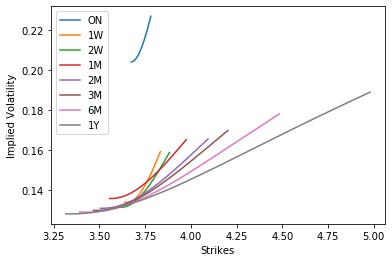

In [66]:
i = 0
for y in md:
    print("-------T =",Tenors[i],"--------")
    withinput_run(y,X2)
    print(" \n \n")
    i+=1
plt.legend(Tenors)
plt.xlabel("Strikes")
plt.ylabel("Implied Volatility")
plt.show()

#### Appendix: try different initial guesses:


 

&  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  
-------T = ON --------
a =  0.20968250632267735
r =  0.06438059832503812
v =  1.7035837849694078
K_ATM =  3.7242141818672585
Vol_ATM =  0.20982058101868
K_RRC =  4.238010860872465
Vol_RRC =  0.24557155455732488
K_RRP =  3.2867537279305954
Vol_RRP =  0.23357186694370918
K_BFC =  3.7523380722617086
Vol_BFC =  0.21036043309723562
K_BFP =  3.696774574771882
Vol_BFP =  0.20954275879979564
K_10call =  3.7776478431350835
K_10put =  3.6725657736589765
 
 
-------T = 1W --------
a =  0.1372349003454759
r =  -0.3101103960013245
v =  3.1551768301116945
K_ATM =  3.726380847347726
Vol_ATM =  0.13910000000049882
K_RRC =  3.7788959172202667
Vol_RRC =  0.14777758719328363
K_RRP =  3.6805091144413398
Vol_RRP =  0.13477758719331212
K_BFC =  3.7765367878871396
Vol_BFC =  0.147325512473125
K_BFP =  3.6783412468973222
Vol_BFP =  0.13466680925600566
K_10call =  3.8344910383931787
K_10put =  3.6396592921895463
 
 
-------T = 2W --------
a =  0.

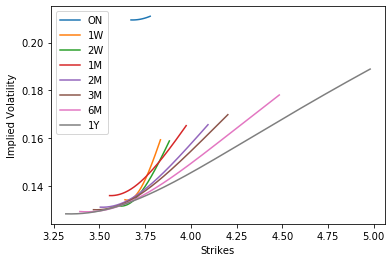


 

&  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  
-------T = ON --------
a =  0.20831557390322297
r =  0.2704261879976352
v =  5.922762693823911
K_ATM =  3.7242141818672585
Vol_ATM =  0.20979999999707705
K_RRC =  3.753147848240699
Vol_RRC =  0.2174065977755467
K_RRP =  3.6975429506464335
Vol_RRP =  0.20540659777728978
K_BFC =  3.7523380722617086
Vol_BFC =  0.21716032173633415
K_BFP =  3.696774574771882
Vol_BFP =  0.2053227413120515
K_10call =  3.7817197986917406
K_10put =  3.6739205153833483
 
 
-------T = 1W --------
a =  0.1372349005296293
r =  0.3101104080668444
v =  3.1551767114904155
K_ATM =  3.726380847347726
Vol_ATM =  0.13910000002247347
K_RRC =  3.7788959171695344
Vol_RRC =  0.14777758705127472
K_RRP =  3.6805091144920383
Vol_RRP =  0.13477758705595558
K_BFC =  3.7765367878871396
Vol_BFC =  0.1473255123533848
K_BFP =  3.6783412468973222
Vol_BFP =  0.1346668091003087
K_10call =  3.8344910379789408
K_10put =  3.6396592925420563
 
 
-------T = 2W --------
a =  0.13

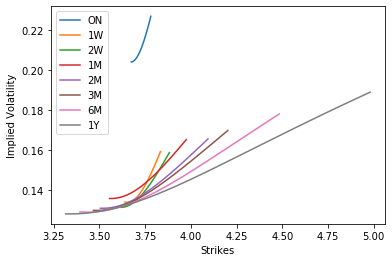


 

&  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  
-------T = ON --------
a =  0.2083155739441366
r =  0.2704261903720087
v =  5.922762642896834
K_ATM =  3.7242141818672585
Vol_ATM =  0.20980000000956622
K_RRC =  3.7531478482387692
Vol_RRC =  0.21740659776109186
K_RRP =  3.697542950648343
Vol_RRP =  0.2054065977624158
K_BFC =  3.7523380722617086
Vol_BFC =  0.21716032172385713
K_BFP =  3.696774574771882
Vol_BFP =  0.20532274129535188
K_10call =  3.7817197986691746
K_10put =  3.6739205154041623
 
 
-------T = 1W --------
a =  0.13723490034453778
r =  0.3101103959685297
v =  3.155176830447899
K_ATM =  3.726380847347726
Vol_ATM =  0.13910000000001288
K_RRC =  3.778895917220259
Vol_RRC =  0.14777758719326375
K_RRP =  3.6805091144413487
Vol_RRP =  0.1347775871932607
K_BFC =  3.7765367878871396
Vol_BFC =  0.14732551247306977
K_BFP =  3.6783412468973222
Vol_BFP =  0.1346668092559974
K_10call =  3.8344910383940576
K_10put =  3.6396592921888464
 
 
-------T = 2W --------
a =  0.135

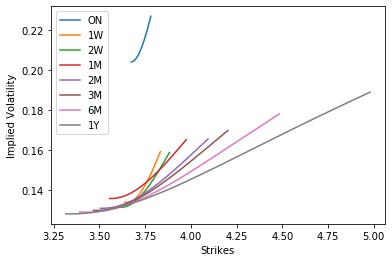

In [68]:
for initial in initials:
    print("\n \n")
    print("&  "*20)
    i = 0
    for y in md:
        print("-------T =",Tenors[i],"--------")
        withinput_run(y,initial)
        print(" \n ")
        i+=1

    plt.legend(Tenors)
    plt.xlabel("Strikes")
    plt.ylabel("Implied Volatility")
    plt.show()
    